# Introduction: Business Problem
In this project we will try to find an optimal neighborhood for a wine lover in Milan.
Specifically this project will be target to people who love wine and are willing to relocate to Milan and also would love to have many wine bars in their neighborhood.
There are many types of venues for wine, like restaurants, bars, cocktail bars and so on, but we're looking for specialized venues where you have a broader choise of wines.
We will use our data science powers to generate the most promising neighborhoods based on this criteria.

# Data
The only factor that will influence our decision is the number of existing wine bars in the neighborhood (only specialized wine bars).
We'll take the neighborhood geo-data (neighborhood name, latitude, longitude) scrapping from the municipality website that contains all these information.
After that we'll need to leverage the power of Foursquare to identify all the wine bars included in the selected distance from the center of the neighborhood.
Then we'll analyse the results and get the conclusions of the research.

Let's install all the libraries that we need and read the data of the neighborhoods from the Milan municipality website, including the list of Neighborhoods with relative latitudes and longitudes

In [1]:
import pandas as pd
!pip install wikipedia
!pip install folium
!pip install geopy
!pip install geopandas
!pip install geojson

Milan_data = pd.read_csv('https://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/3fce7202-0076-4a7b-ac2c-d2ab9b5dc658/download/ds964_nil_wm_4326.csv', delimiter=';')


In [2]:
#lets take a look to the data
MD0=Milan_data.drop(columns=['ID_NIL','Valido_dal', 'Valido_al', 'Fonte', 'Shape_Length', 'Shape_Area', 'OBJECTID', 'Location'])
MD=MD0.rename(columns={"NIL": "Neighborhood", "LONG_X_4326_CENTROID": "Longitude", "LAT_Y_4326_CENTROID":"Latitude"})
MD.head()

,Neighborhood,Longitude,Latitude
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,9.137260,45.438460
1,TRENNO,9.101675,45.492822
2,PORTELLO,9.153947,45.484490
3,BOVISASCA,9.156731,45.517433
4,PARCO NORD,9.184235,45.523514


# Methodology
In this project we will direct our efforts on detecting the neighborhoods of Milan that have high wine bars density. We will limit our analysis to 500m around each neighborhood center.
We've collected the neighborhoods data with longitudes and latitudes. We'll plot the map of Milan identifing the neighborhoods centers.
Then we'll leverage Foursquare power building a dataframe containing all wine bars venues for each neighborhood.
Finally we'll analyse the results grouping by neighborhood and identifing the number of wine bars, plotting it in a bar chart showing the solution.

In [3]:
#let's find the coordinates of Milan
import pandas as pd
from pandas.io.json import json_normalize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np 
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium 
from folium import plugins
from folium.plugins import HeatMap

address = 'Milano, Italy'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Milan are 45.4668, 9.1905.


Let's identify the neighborhoods of Milan using a map

In [4]:
# let's plot the map of Milan

map_milan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for Latitude, Longitude, Neighborhood in zip(MD['Latitude'], 
                                           MD['Longitude'], 
                                           MD['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

# Analysis
That's probably our most important step. Now we need to perform the merger between our neighborhoods coordinates and the selected venues in Foursquare. We've identified the ID category of wine bars, but we need to check whether all the results are compliant with our research.
Than we'll group by neighborhood counting the number of wine bars present in each one and finally we'll plot the results in a bar chart.

In [5]:
#Let's extract the venues for each neighborhood using foursquare

CLIENT_ID = '0UYD3HV2JM4JBY40LI5OTDF24XZD3MEENNWMIYCATT0UIDFI'
CLIENT_SECRET = '5FDGC2J33OIVUQFJB4EQQZ40XC2IZJJTPHN1INPDHYXHLNYS'
VERSION = '20200605'
LIMIT = 100 # limit of number of venues returned by Foursquare API
categoryId='4bf58dd8d48988d123941735'
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
           

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)




In [6]:
milan_winebars = getNearbyVenues(names=MD['Neighborhood'],
                                   latitudes=MD['Latitude'],
                                   longitudes=MD['Longitude']
                                  )
print(milan_winebars.shape)
milan_winebars.head()

#let's take a look at all the different neighborhoods and the dataframe derived

RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO
TRENNO
PORTELLO
BOVISASCA
PARCO NORD
FIGINO
LORETO - CASORETTO - NOLO
QUARTO OGGIARO - VIALBA - MUSOCCO
ISOLA
QUARTO CAGNINO
STADIO - IPPODROMI
QUINTO ROMANO
DUOMO
GUASTALLA
SAN SIRO
COMASINA
TIBALDI
GRECO - SEGNANO
DE ANGELI - MONTE ROSA
FARINI
BRUZZANO
QT 8
STEPHENSON
CANTALUPA
QUINTOSOLE
PARCO SEMPIONE
BARONA
VILLAPIZZONE - CAGNOLA - BOLDINASCO
PARCO BOSCO IN CITTA'
GORLA - PRECOTTO
NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
TRIULZO SUPERIORE
PTA ROMANA
TALIEDO - MORSENCHIO - Q.RE FORLANINI
PORTA TICINESE - CONCA DEL NAVIGLIO
TRE TORRI
ASSIANO
MORIVIONE
VIGENTINO - Q.RE FATIMA
BICOCCA
ORTOMERCATO
LODI - CORVETTO
MUGGIANO
PORTA TICINESE - CONCHETTA
UMBRIA - MOLISE - CALVAIRATE
ROSERIO
RONCHETTO DELLE RANE
Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO
MONLUE' - PONTE LAMBRO
PADOVA - TURRO - CRESCENZAGO
GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE
PORTA MAGENTA
FORZE ARMATE
GHISOLFA
CHIARAVALLE
PARCO DELLE ABBAZIE
MACI

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PORTELLO,45.484490,9.153947,Urban Food,45.487050,9.155120,Wine Bar
1,ISOLA,45.490894,9.189617,Il Borsieri,45.489456,9.189092,Wine Bar
2,ISOLA,45.490894,9.189617,Cantine Milano,45.490012,9.190418,Wine Bar
3,ISOLA,45.490894,9.189617,Ebrezza,45.488365,9.189756,Wine Bar
4,ISOLA,45.490894,9.189617,Frida,45.488718,9.187129,Cocktail Bar


We can see that the are a certain number of venues which are not specifically wine bars. So we need to explicit this request and then find the number of wine bars for each neighborhood.

In [7]:
#let's explore the data
MDA1=milan_winebars[["Neighborhood","Venue Category"]]
MDA2=MDA1.loc[MDA1['Venue Category']=='Wine Bar']
MDA=MDA2.groupby(["Neighborhood"]).count()
MDA.sum()


Venue Category    73
dtype: int64

The first result that we have found is that we have 73 wine bars in Milan, what a city for a wine lover!
Lets see which neighborhood is the wine paradise.

In [8]:
MDA

,Venue Category
Neighborhood,
BANDE NERE,2
BRERA,9
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,4
CORSICA,2
DE ANGELI - MONTE ROSA,4
DUOMO,6
FORZE ARMATE,1
GHISOLFA,2
GIAMBELLINO,1


A chart can help us to better visualize the results.

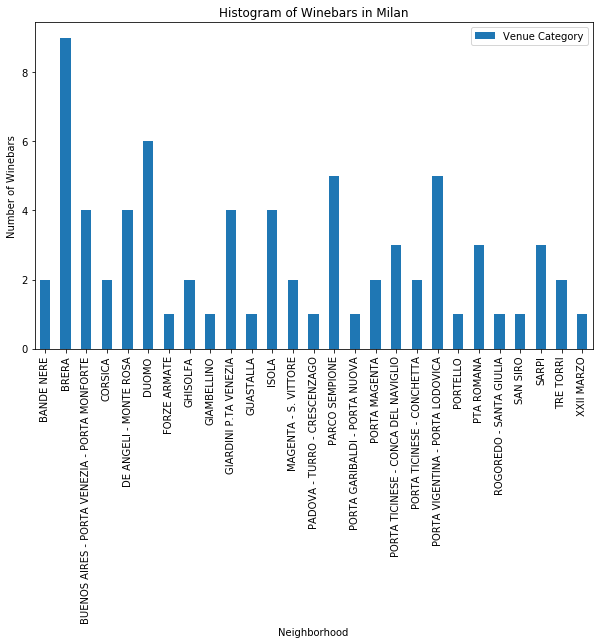

In [9]:
MDA.plot(kind='bar', figsize=(10, 6))

plt.title('Histogram of Winebars in Milan') # add a title to the histogram
plt.ylabel('Number of Winebars') # add y-label
plt.xlabel('Neighborhood') # add x-label

plt.show()

# Results and discussion
Our analysis show that we have only 27 out of 83 neighborhoods including at least one wine bar. We can see that there is a higher concentration of wine bars in the most central neighbohoods like Duomo, Brera, Parco Sempione, Porta Venezia that are also very turistic.
The winner neighborhood is Brera, which is located in the cenral area 1 of Milan and is a very elegant and artist neighborhood, now also a wine lover paradise.


# Conclusion
Purpose of this project was to identify Milan areas with an high density of wine bars so that a wine lover who is looking to relocate in Milan can find his/her optimal location to live and spend some time. By calculating the number of wine bars for each neighborhood we can conclude that the best solution will be to live near the city center, between Brera and Duomo.